In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
BATCH_SIZE = 64
from torch.utils.data import DataLoader
def dataloader(train_dataset, test_dataset, batch_size):
    return (
        DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True), 
        DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False),
        train_dataset.classes
    )
train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [4]:
# new conv
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [5]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(
        *layers, 
        conv(nfs[-1], 10, act=None, norm=norm, bias=True), 
        nn.Flatten()
    )

In [6]:
model = get_model(norm=nn.BatchNorm2d)

In [7]:
lr = 6e-2
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))

In [8]:
# in utils.py
import matplotlib.pyplot as plt
def plot_curves(results):
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, results["train_loss"], label="Train Loss")
    plt.plot(epochs, results["test_loss"], label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results["train_acc"], label="Train Accuracy")
    plt.plot(epochs, results["test_acc"], label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

In [9]:
from torcheval.metrics import MulticlassAccuracy, Mean
accuracy_metric = MulticlassAccuracy(device=device)
loss_metric = Mean(device=device)

d:\Machine Learning\pytorch\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [10]:
# in utils.py
def compute_result(loss_metric, accuracy_metric):
    lm = loss_metric.compute().item()
    am = accuracy_metric.compute().item()
    loss_metric.reset()
    accuracy_metric.reset()
    return lm, am

In [11]:
# in train.py
def train(model, train_dataloader, loss_fn, optimizer, device):
    model.train()
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_metric.update(loss)
        accuracy_metric.update(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return compute_result(loss_metric, accuracy_metric)

In [12]:
# in train.py
def evaluate(model, test_dataloader, loss_fn, device):
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            loss_metric.update(loss)
            accuracy_metric.update(pred, y)

    return compute_result(loss_metric, accuracy_metric)

In [13]:
# in train.py
from tqdm.notebook import trange
from IPython.display import display

def fit(epochs, model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, device):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    model.to(device)

    progress_bar = trange(epochs, desc="Progress")
    display(progress_bar)

    print("\t     Train\t\t     Test")
    print("Epoch\tLoss\tAccuracy\tLoss\tAccuracy")

    for epoch in progress_bar:
        train_loss, train_acc = train(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = evaluate(model, test_dataloader, loss_fn, device)
                
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        print(f"{epoch}\t{train_loss:.3f}\t{train_acc:.3f}\t\t{test_loss:.3f}\t{test_acc:.3f}")
        
        scheduler.step()
    
    return results

In [14]:
results = fit(epochs=15, model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, device=device)

Progress:   0%|          | 0/15 [00:00<?, ?it/s]

	     Train		     Test
Epoch	Loss	Accuracy	Loss	Accuracy
0	0.484	0.859		0.332	0.886
1	0.315	0.895		0.296	0.896
2	0.263	0.911		0.265	0.903
3	0.236	0.919		0.242	0.916
4	0.208	0.928		0.240	0.916
5	0.188	0.934		0.239	0.915
6	0.174	0.939		0.230	0.921
7	0.155	0.945		0.268	0.910
8	0.143	0.949		0.246	0.919
9	0.131	0.954		0.246	0.922
10	0.118	0.960		0.242	0.923
11	0.105	0.963		0.269	0.913
12	0.098	0.966		0.268	0.914
13	0.090	0.969		0.255	0.922
14	0.086	0.971		0.266	0.915


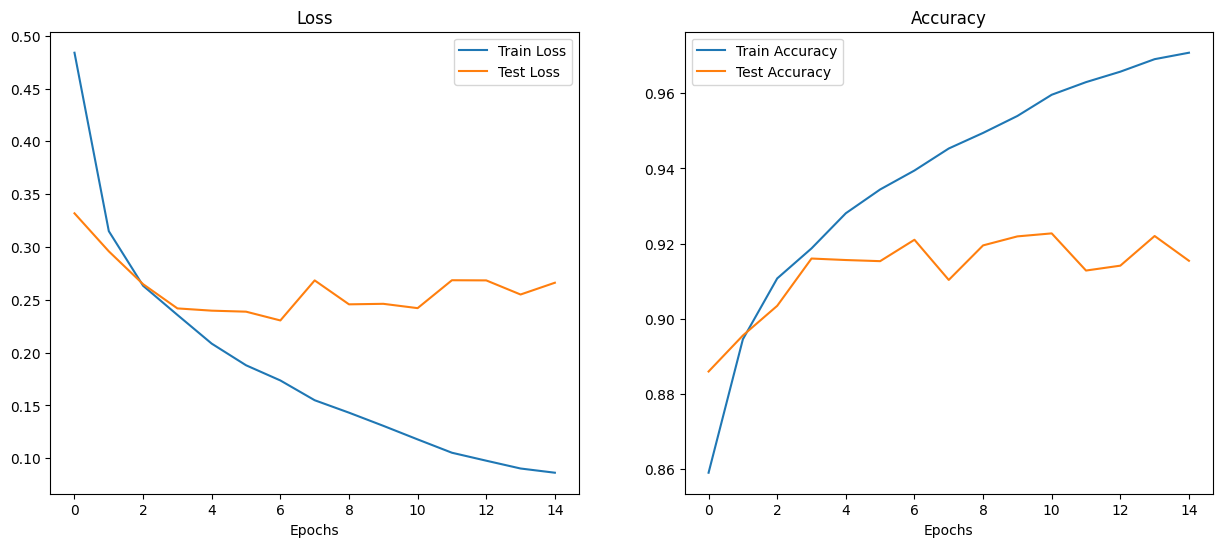

In [15]:
plot_curves(results)